In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
    )
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.utils import class_weight

from catboost import CatBoostClassifier
import time

import random

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
normal_df = pd.read_parquet('/kaggle/input/cicids2017/Benign-Monday-no-metadata.parquet')
ddos_df = pd.read_parquet('/kaggle/input/cicids2017/DDoS-Friday-no-metadata.parquet')
dos_df = pd.read_parquet('/kaggle/input/cicids2017/DoS-Wednesday-no-metadata.parquet')
portscan_df = pd.read_parquet('/kaggle/input/cicids2017/Portscan-Friday-no-metadata.parquet')

df = pd.concat([normal_df, ddos_df, dos_df, portscan_df], ignore_index=True)
df

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,6,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,6,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,6,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,6,609,7,4,484,414,233,0,69.142860,111.967896,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384603,6,196135,49,57,1331,105841,570,0,27.163265,108.067177,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1384604,6,378424,49,59,1325,104393,570,0,27.040817,108.095047,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1384605,6,161800,70,103,1427,215903,570,0,20.385714,90.746391,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1384606,6,142864,50,62,1331,110185,570,0,26.620001,107.027725,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [3]:
print(df.shape)
df.info()

(1384608, 78)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384608 entries, 0 to 1384607
Data columns (total 78 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Protocol                  1384608 non-null  int8   
 1   Flow Duration             1384608 non-null  int32  
 2   Total Fwd Packets         1384608 non-null  int32  
 3   Total Backward Packets    1384608 non-null  int32  
 4   Fwd Packets Length Total  1384608 non-null  int32  
 5   Bwd Packets Length Total  1384608 non-null  int32  
 6   Fwd Packet Length Max     1384608 non-null  int16  
 7   Fwd Packet Length Min     1384608 non-null  int16  
 8   Fwd Packet Length Mean    1384608 non-null  float32
 9   Fwd Packet Length Std     1384608 non-null  float32
 10  Bwd Packet Length Max     1384608 non-null  int16  
 11  Bwd Packet Length Min     1384608 non-null  int16  
 12  Bwd Packet Length Mean    1384608 non-null  float32
 13  Bwd Packet Le

In [4]:
pd.set_option('display.max_rows', None)
print(df.nunique())
pd.set_option('display.max_rows', 10)
print(df['Label'].value_counts())

Protocol                          3
Flow Duration                746953
Total Fwd Packets               996
Total Backward Packets         1255
Fwd Packets Length Total      13903
Bwd Packets Length Total      42519
Fwd Packet Length Max          4634
Fwd Packet Length Min           317
Fwd Packet Length Mean        57446
Fwd Packet Length Std        138261
Bwd Packet Length Max          4475
Bwd Packet Length Min           502
Bwd Packet Length Mean        83481
Bwd Packet Length Std        130918
Flow Bytes/s                1044773
Flow Packets/s               862610
Flow IAT Mean                793505
Flow IAT Std                 636601
Flow IAT Max                 430339
Flow IAT Min                  91673
Fwd IAT Total                346781
Fwd IAT Mean                 451484
Fwd IAT Std                  414943
Fwd IAT Max                  306548
Fwd IAT Min                   80184
Bwd IAT Total                332145
Bwd IAT Mean                 449957
Bwd IAT Std                 

In [5]:
pd.set_option('display.max_rows', None)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
display(df[num_cols].describe().T[['count','mean','std','min','25%','50%','75%','max']])
pd.set_option('display.max_rows', 10)

,count,mean,std,min,25%,50%,75%,max
Protocol,1384608.0,9.888485e+00,5.264006e+00,0.000000e+00,6.000000,6.000000,1.700000e+01,1.700000e+01
Flow Duration,1384608.0,2.173418e+07,3.876067e+07,-1.300000e+01,8987.750000,116841.000000,1.111549e+07,1.200000e+08
Total Fwd Packets,1384608.0,9.885781e+00,7.643454e+02,1.000000e+00,2.000000,3.000000,7.000000e+00,2.197590e+05
Total Backward Packets,1384608.0,1.081056e+01,1.005845e+03,0.000000e+00,1.000000,2.000000,6.000000e+00,2.919220e+05
Fwd Packets Length Total,1384608.0,6.772043e+02,6.020787e+03,0.000000e+00,30.000000,74.000000,3.670000e+02,1.323378e+06
Bwd Packets Length Total,1384608.0,1.688092e+04,2.291990e+06,0.000000e+00,26.000000,202.000000,4.845000e+03,6.554530e+08
Fwd Packet Length Max,1384608.0,2.908843e+02,9.224849e+02,0.000000e+00,20.000000,44.000000,3.260000e+02,2.482000e+04
Fwd Packet Length Min,1384608.0,2.033542e+01,7.511642e+01,0.000000e+00,0.000000,6.000000,3.600000e+01,2.293000e+03
Fwd Packet Length Mean,1384608.0,7.897630e+01,2.413638e+02,0.000000e+00,8.666667,40.000000,5.600000e+01,4.640758e+03
Fwd Packet Length Std,1384608.0,1.022025e+02,3.776624e+02,0.000000e+00,0.000000,0.000000,1.149049e+02,7.125597e+03


In [6]:
negative_anomaly_features = [
    'Flow Duration', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 
    'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min',
    'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min',
    'Flow Bytes/s', 'Flow Packets/s', 
    'Fwd Header Length', 'Bwd Header Length', 'Fwd Seg Size Min',
    'Init Fwd Win Bytes', 'Init Bwd Win Bytes' 
]

existing_cols = [col for col in negative_anomaly_features if col in df.columns]

negative_mask = (df[existing_cols] < 0)

count_per_feature = negative_mask.sum().sort_values(ascending=False)

df['Negative_Count'] = negative_mask.sum(axis=1)

anomalous_rows_count = (df['Negative_Count'] > 0).sum()
total_rows = df.shape[0]
percent_anomalous = (anomalous_rows_count / total_rows) * 100

print(f"Общее количество строк: {total_rows}")
print(f"Количество строк с хотя бы одной отрицательной аномалией: {anomalous_rows_count} ({percent_anomalous:.4f}%)")

print(count_per_feature[count_per_feature > 0])

print(df['Negative_Count'].describe())

df.drop('Negative_Count', axis=1, inplace=True)

--------------------------------------------------
Общее количество строк: 1384608
Количество строк с хотя бы одной отрицательной аномалией: 644798 (46.5690%)
--------------------------------------------------
Init Bwd Win Bytes    643303
Init Fwd Win Bytes    490647
Flow IAT Min            1506
Flow IAT Max              48
Flow IAT Mean             48
                       ...  
Flow Bytes/s              37
Fwd Seg Size Min          24
Fwd Header Length         24
Fwd IAT Min               17
Bwd Header Length         17
Length: 12, dtype: int64

--------------------------------------------------
count    1.384608e+06
mean     8.202805e-01
std      9.259728e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      6.000000e+00
Name: Negative_Count, dtype: float64
--------------------------------------------------


Data Preproccesing1. 

In [7]:
columns_to_drop = [
    'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'CWE Flag Count',
    'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
    'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'
]
df.drop(columns=columns_to_drop, inplace=True)

print(df.duplicated().sum())
df.drop_duplicates(inplace=True, ignore_index=True)
df.shape

15993


(1368615, 68)

Используются 67 числовых признаков из 68 исходных.


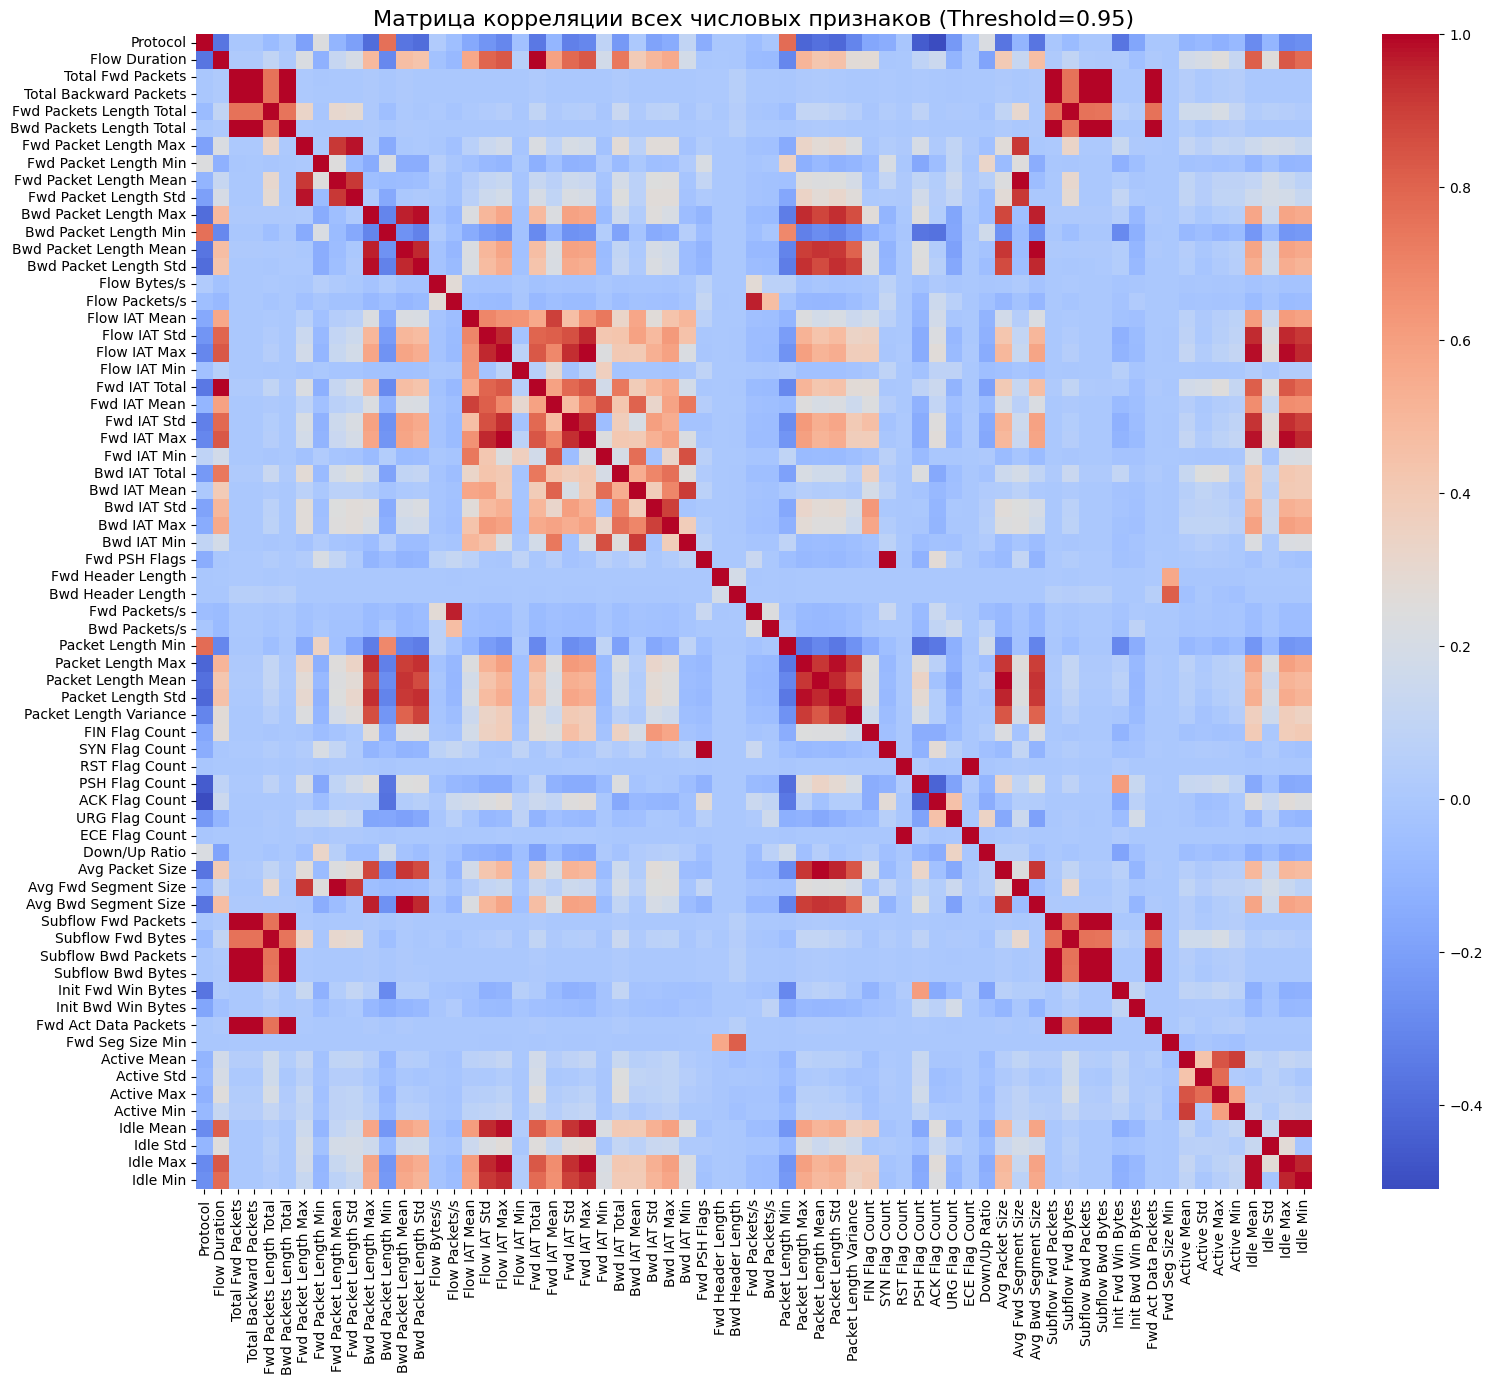

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Признаки, которые будут удалены (корреляция > 0.95): ['Total Backward Packets', 'Bwd Packets Length Total', 'Fwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Max', 'Fwd Packets/s', 'Packet Length Std', 'SYN Flag Count', 'ECE Flag Count', 'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Fwd Act Data Packets', 'Idle Mean', 'Idle Max', 'Idle Min']
Количество числовых признаков до: 67
Количество числовых признаков после: 44


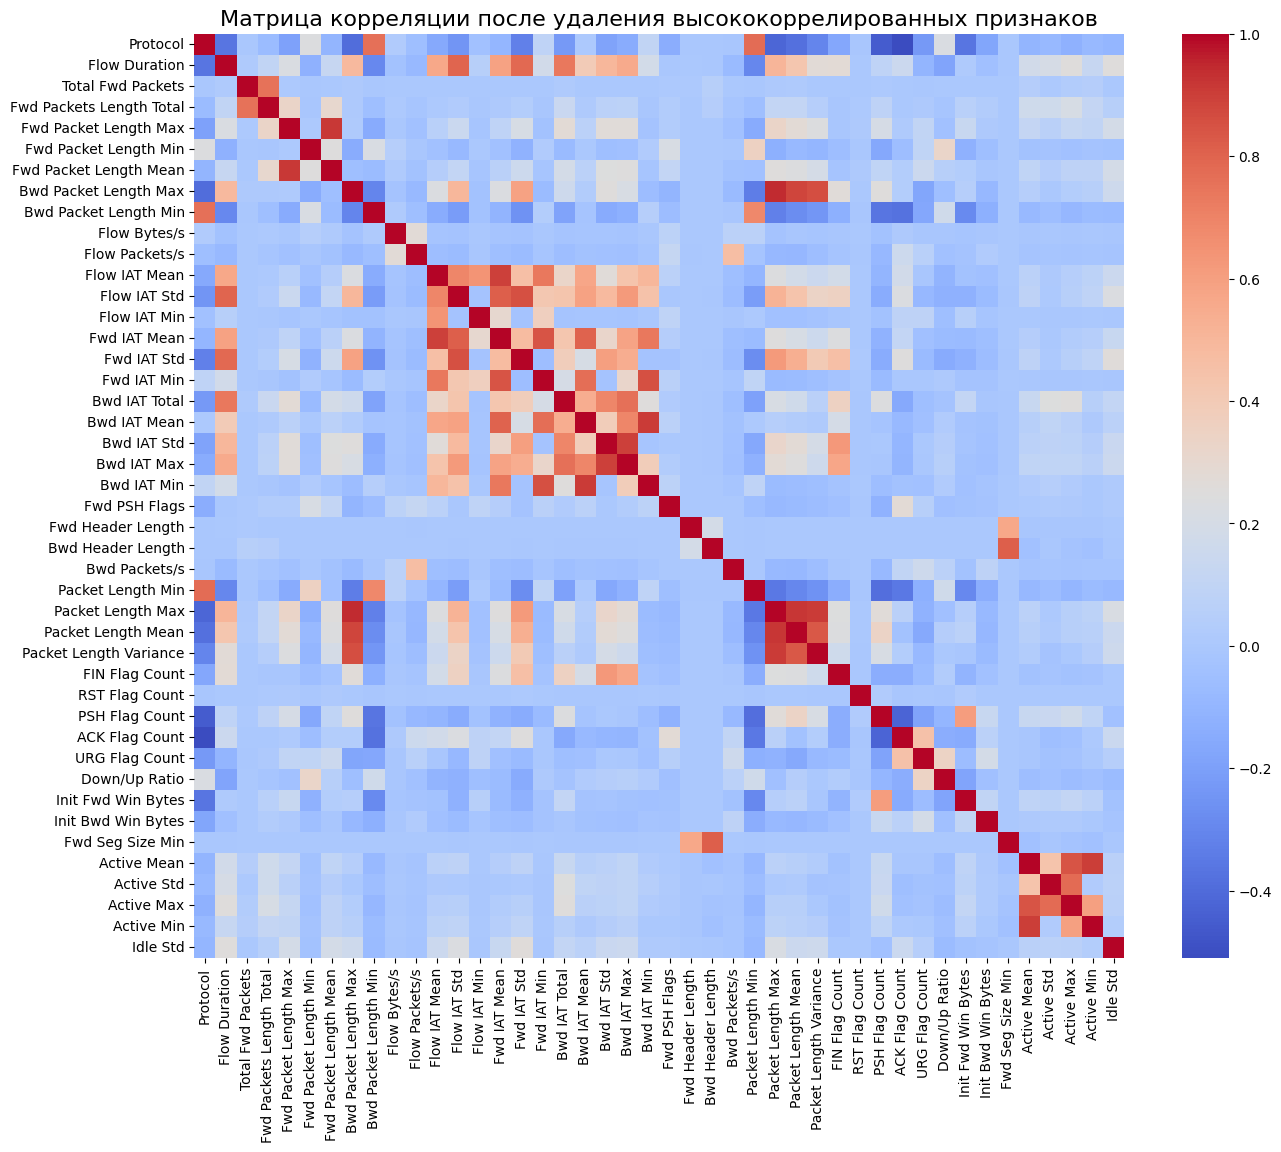

In [8]:
CORR_THRESHOLD = 0.95

df_numeric = df.select_dtypes(include=np.number).copy()
print(f"Используются {df_numeric.shape[1]} числовых признаков из {df.shape[1]} исходных.")

corr_matrix_full = df_numeric.corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix_full, annot=False, cmap='coolwarm', fmt=".2f")
plt.title(f'Матрица корреляции всех числовых признаков (Threshold={CORR_THRESHOLD})', fontsize=16)
plt.show()

corr_matrix = df_numeric.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > CORR_THRESHOLD)]

df_reduced_numeric = df_numeric.drop(columns=to_drop, axis=1)

print(f"Признаки, которые будут удалены (корреляция > {CORR_THRESHOLD}): {to_drop}")
print(f"Количество числовых признаков до: {df_numeric.shape[1]}")
print(f"Количество числовых признаков после: {df_reduced_numeric.shape[1]}")

non_numeric_cols = df.select_dtypes(exclude=np.number).columns
df_final = pd.concat([df[non_numeric_cols], df_reduced_numeric], axis=1)

df = df_final

corr_matrix_new = df_reduced_numeric.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix_new, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции после удаления высококоррелированных признаков', fontsize=16)
plt.show()

In [9]:
label_mapping = {
    'Benign': 'Benign',
    'DDoS': 'DDoS',
    'PortScan': 'PortScan',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'Heartbleed': 'Other' 
}

df['Label'] = df['Label'].replace(label_mapping)

df = df[df['Label'] != 'Other'].copy()

le = LabelEncoder()
target_classes = ['Benign', 'DDoS', 'DoS','PortScan']
le.fit(target_classes)
df['Label'] = le.transform(df['Label'])



In [10]:
label_counts_encoded = df['Label'].value_counts().sort_index()
decoded_labels = le.inverse_transform(label_counts_encoded.index)
label_attack_counts = dict(zip(decoded_labels, label_counts_encoded.values))
for label, count in label_attack_counts.items():
    print(f"{label} : {count}")

📊 Метка : Атака : Количество объектов
---
Benign : 1044889
DDoS : 128014
DoS : 193745
PortScan : 1956


In [11]:
df_num = df.select_dtypes(include=[np.number]).columns

df[df_num] = df[df_num].clip(lower=0)

In [12]:
df = pd.get_dummies(df, columns=['Protocol'], prefix='Protocol', drop_first=True) 
protocol_cols = [col for col in df.columns if col.startswith('Protocol_')] 
print(protocol_cols)

['Protocol_6', 'Protocol_17']


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1368604 entries, 0 to 1368614
Data columns (total 46 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Label                     1368604 non-null  int64  
 1   Flow Duration             1368604 non-null  int32  
 2   Total Fwd Packets         1368604 non-null  int32  
 3   Fwd Packets Length Total  1368604 non-null  int32  
 4   Fwd Packet Length Max     1368604 non-null  int16  
 5   Fwd Packet Length Min     1368604 non-null  int16  
 6   Fwd Packet Length Mean    1368604 non-null  float32
 7   Bwd Packet Length Max     1368604 non-null  int16  
 8   Bwd Packet Length Min     1368604 non-null  int16  
 9   Flow Bytes/s              1368604 non-null  float64
 10  Flow Packets/s            1368604 non-null  float64
 11  Flow IAT Mean             1368604 non-null  float32
 12  Flow IAT Std              1368604 non-null  float32
 13  Flow IAT Min              136860

In [14]:
X = df.drop(columns=['Label'])
Y = df['Label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, Y, test_size=0.30, stratify=Y, random_state=42
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weights_dict = dict(zip(np.unique(y_train), class_weights))
print(f"Веса классов: {weights_dict}")

X_test.to_csv('test_data.csv', index=False)

Веса классов: {0: 0.32745186773162416, 1: 2.6727541569021316, 2: 1.7659912550416232, 3: 174.94923301680058}


In [15]:
def evaluate(model, name, y_test, X_test):
    print(f"\n=== {name} ===")

    t0 = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - t0

    classes = np.unique(y_test)


    precisions = precision_score(y_test, y_pred, average=None, labels=classes, zero_division=0) * 100
    recalls    = recall_score(y_test, y_pred, average=None, labels=classes, zero_division=0) * 100
    f1s        = f1_score(y_test, y_pred, average=None, labels=classes, zero_division=0) * 100

    support = (
        pd.Series(y_test)
        .value_counts()
        .sort_index()
        .reindex(classes, fill_value=0)
        .values
    )

    acc_total = accuracy_score(y_test, y_pred) * 100
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0) * 100
    prec_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0) * 100
    rec_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0) * 100

    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0) * 100
    prec_macro = precision_score(y_test, y_pred, average='macro', zero_division=0) * 100
    rec_macro = recall_score(y_test, y_pred, average='macro', zero_division=0) * 100

    print(f"Accuracy (Total): {acc_total:.6f}%")
    print(f"  Precision (Weighted): {prec_weighted:.6f}%")
    print(f"  Recall (Weighted): {rec_weighted:.6f}%")
    print(f"  F1-score (Weighted): {f1_weighted:.6f}%")
    print(f"  Precision (Macro): {prec_macro:.6f}%")
    print(f"  Recall (Macro): {rec_macro:.6f}%")
    print(f"  F1-score (Macro): {f1_macro:.6f}%")
    print(f"\nPrediction time: {pred_time:.6f} sec")

    print("Отчет по классификации")
    header = f"{'Class':<8} | {'Precision (%)':>15} | {'Recall (%)':>13} | {'F1-score (%)':>14} | {'Support':>10}"
    print(header)
    print("-" * len(header))

    for i, cls in enumerate(classes):
        print(
            f"{cls:<8} | "
            f"{precisions[i]:>15.6f} | "
            f"{recalls[i]:>13.6f} | "
            f"{f1s[i]:>14.6f} | "
            f"{support[i]:>10}"
        )

    return {
        "model": name,
        "accuracy": acc_total,
        "precision_weighted": prec_weighted,
        "recall_weighted": rec_weighted,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro, 
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "pred_time": pred_time
    }

In [16]:
results = []

t0 = time.time()

model_cat = CatBoostClassifier(
    loss_function='MultiClass',
    iterations=500,
    learning_rate=0.15,
    depth=8,
    random_state=42,
    thread_count=-1,
    task_type='GPU',
    l2_leaf_reg=3,

    class_weights=weights_dict, 
)

model_cat.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    verbose=100,
    early_stopping_rounds=50
)

train_time = time.time() - t0
print(f"Train time: {train_time:.3f} sec")
print(f"Best iteration: {model_cat.get_best_iteration()}")

results.append(evaluate(model_cat, "CatBoost", y_test, X_test))

0:	learn: 1.0012773	test: 0.9978168	best: 0.9978168 (0)	total: 368ms	remaining: 3m 3s
100:	learn: 0.0048323	test: 0.0084989	best: 0.0081775 (78)	total: 2.61s	remaining: 10.3s
bestTest = 0.00785523467
bestIteration = 143
Shrink model to first 144 iterations.
Train time: 6.654 sec
Best iteration: 143

=== CatBoost ===
Accuracy (Total): 99.919626%

Средневзвешенные метрики (Weighted - учитывают размер классов):
  Precision (Weighted): 99.921316%
  Recall (Weighted): 99.919626%
  F1-score (Weighted): 99.920080%

Средние метрики (Macro - все классы равнозначны):
  Precision (Macro): 97.345119%
  Recall (Macro): 99.858797%
  F1-score (Macro): 98.538408%

Prediction time: 0.263463 sec
Отчет по классификации
Class    |   Precision (%) |    Recall (%) |   F1-score (%) |    Support
------------------------------------------------------------------------
0        |       99.992338 |     99.919609 |      99.955960 |     156734
1        |       99.864731 |     99.963545 |      99.914114 |      1920

In [17]:
MODEL_FILE_NAME = 'catboost_model_final.cbm' 
model_cat.save_model(MODEL_FILE_NAME)
model_cat.save_model('catboost_model.json', format='json')
model_cat.save_model('catboost_model.cpp', format='cpp')

Модель CatBoost сохранена в файл: catboost_model_final.cbm


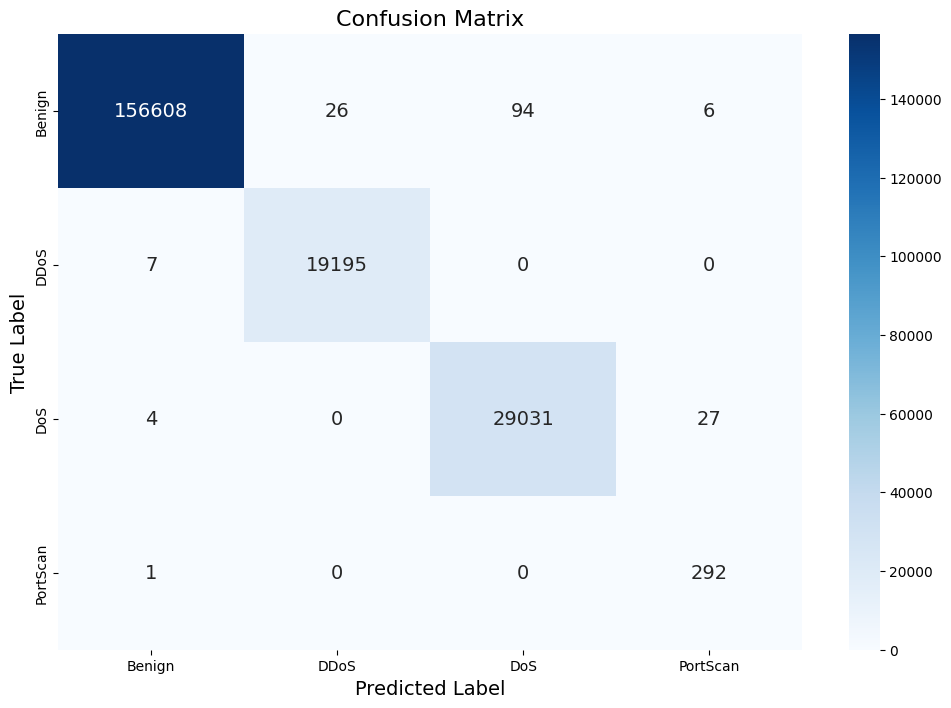

In [18]:
y_pred = model_cat.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

labels = ['Benign', 'DDoS', 'DoS','PortScan']

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.show()

In [19]:
y_proba = model_cat.predict_proba(X_test)

roc_auc_ovr = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")
roc_auc_ovo = roc_auc_score(y_test, y_proba, multi_class="ovo", average="macro")
print(f"ROC-AUC (OVR, macro): {roc_auc_ovr:.6f}")
print(f"ROC-AUC (OVO, macro): {roc_auc_ovo:.6f}")

ROC-AUC (OVR, macro): 0.999632
ROC-AUC (OVO, macro): 0.999597

Примечание: Для несбалансированных данных PR-AUC более информативен, чем ROC-AUC


Average Precision (PR-AUC) [Micro-average]: 1.0000
Average Precision (PR-AUC) [Macro-average]: 0.9990
PR-AUC по классам
Класс 0 (Benign): 1.0000
Класс 1 (DDoS): 1.0000
Класс 2 (DoS): 0.9999
Класс 3 (PortScan): 0.9960


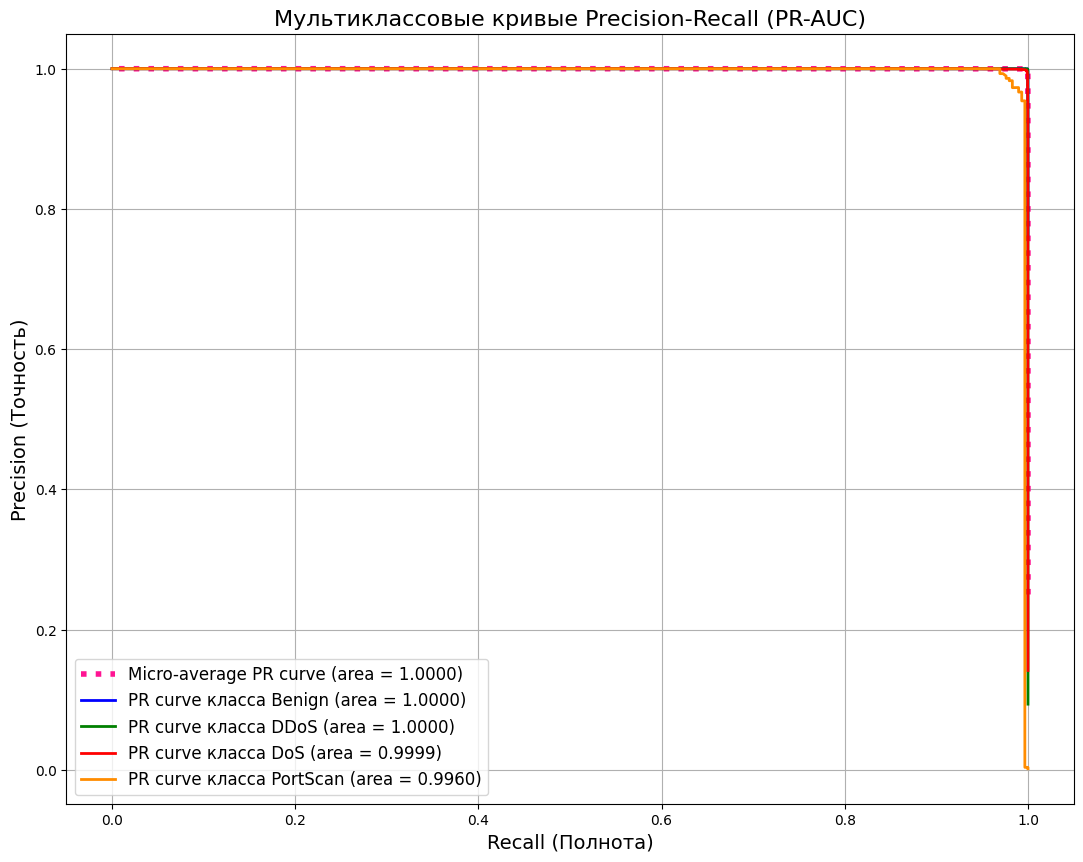

In [20]:
classes = le.classes_
n_classes = len(classes)
unique_classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=unique_classes)


precision = dict()
recall = dict()
pr_auc = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    pr_auc[i] = average_precision_score(y_test_bin[:, i], y_proba[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_proba.ravel())
pr_auc["micro"] = average_precision_score(y_test_bin, y_proba, average="micro")

pr_auc["macro"] = average_precision_score(y_test_bin, y_proba, average="macro")

print(f"Average Precision (PR-AUC) [Micro-average]: {pr_auc['micro']:.4f}")
print(f"Average Precision (PR-AUC) [Macro-average]: {pr_auc['macro']:.4f}")
print("PR-AUC по классам")
for i in range(n_classes):
    print(f"Класс {i} ({classes[i]}): {pr_auc[i]:.4f}")

plt.figure(figsize=(13, 10))


plt.plot(recall["micro"], precision["micro"],
         label=f'Micro-average PR curve (area = {pr_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)


colors = ['blue', 'green', 'red', 'darkorange', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'PR curve класса {classes[i]} (area = {pr_auc[i]:.4f})')

plt.xlabel('Recall (Полнота)', fontsize=14)
plt.ylabel('Precision (Точность)', fontsize=14)
plt.title('Мультиклассовые кривые Precision-Recall (PR-AUC)', fontsize=16)
plt.legend(loc="lower left", fontsize=12)
plt.grid(True)
plt.show()